# Zillow Project

In [142]:
# Imports necessary for the notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import math
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

import os
import wrangle
from env import host, user, password

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# I. Acquiring the data for preparation

At this point I have created a function <font color = 'brown'>get_connection</font> that uses login info from env.py file to access Codeup database.

It returns a string that can be used in another function <font color = 'brown'>wrangle_zillow</font> to return a dataframe from the SQL database

In [2]:
# Getting the file

properties_2017 = wrangle.wrangle_zillow()

# II. Cleaning and Preparing the data

* Plan
    - Check for null values and drop them if they are not in great numbers (for example more than 15% of the data. This will also depend on the size of the data)
    - Check for hard to read columns names to rename them appropriately
    - Check for irrelevant columns (that won't impact the analysis and the modeling) and drop them
    - Check for incompatible data types (example: data should be int64 but is object or float)
    - Do a univariate exploration through charts and columns observation

## A. general examination of the data, the columns, rows, and entries

In [3]:
# Displaying the dataframe to take a look at it

properties_2017.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,propertylandusetypeid,transactiondate
0,4.0,3.5,3100.0,1023282.0,261.0,2017-01-01
1,2.0,1.0,1465.0,464000.0,261.0,2017-01-01
2,3.0,2.0,1243.0,564778.0,261.0,2017-01-01
3,4.0,3.0,2376.0,145143.0,261.0,2017-01-01
4,4.0,3.0,2962.0,773303.0,261.0,2017-01-01


In [4]:
# Getting information about number of coulumns, number of rows data type, size of the file (for pushing to github)

properties_2017.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52442 non-null  float64
 1   bathroomcnt                   52442 non-null  float64
 2   calculatedfinishedsquarefeet  52360 non-null  float64
 3   taxvaluedollarcnt             52441 non-null  float64
 4   propertylandusetypeid         52442 non-null  float64
 5   transactiondate               52442 non-null  object 
dtypes: float64(5), object(1)
memory usage: 2.8+ MB


In [6]:
# Getting the proportion of null values in the data

round(properties_2017.isnull().mean(), 4)

bedroomcnt                      0.0000
bathroomcnt                     0.0000
calculatedfinishedsquarefeet    0.0016
taxvaluedollarcnt               0.0000
propertylandusetypeid           0.0000
transactiondate                 0.0000
dtype: float64

In [7]:
for column in properties_2017.columns:
    print(column)
    print(properties_2017[column].value_counts())
    print('\n##########################\n')

bedroomcnt
3.0     23360
4.0     15240
2.0      8340
5.0      3973
6.0       635
1.0       612
0.0       137
7.0       106
8.0        24
9.0         8
12.0        3
10.0        2
14.0        1
11.0        1
Name: bedroomcnt, dtype: int64

##########################

bathroomcnt
2.0     21894
3.0     10673
1.0      9568
2.5      3934
4.0      2227
3.5       918
1.5       841
5.0       803
4.5       687
6.0       322
5.5       224
0.0       121
7.0        88
8.0        53
6.5        47
7.5        16
9.0        13
10.0        5
11.0        3
8.5         3
18.0        1
13.0        1
Name: bathroomcnt, dtype: int64

##########################

calculatedfinishedsquarefeet
1120.0    128
1200.0    119
1080.0    102
1040.0     86
936.0      86
         ... 
7088.0      1
604.0       1
5422.0      1
534.0       1
5655.0      1
Name: calculatedfinishedsquarefeet, Length: 4723, dtype: int64

##########################

taxvaluedollarcnt
455000.0    34
600000.0    30
550000.0    24
500000.0    24

### Takeaways
* Observations
    - There are very few null values
    - The column names are hard to read
    - There are no numbers behind the comma of bedroomcnt, calculatedfinishedsquarefeet, and taxvaluedollarcnt
    - The transactiondate is an object type, cannot be scaled
* Actions
    - Drop null values and transactiondate which is not needed for the MVP
    - The propertylandusetypeid column can be dropped. It is an identifier for the type of house I am working on
    - Convert bedroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, and transactiondate to int
    - Leave bathroomcnt as is
    - Rename columns
    - Move to univariate exploration

## B. Preforming Actions planned in previous step

In [9]:
# Dropping the null values and reassigning properties_2017 to houses

houses = properties_2017.dropna(axis = 0, how ='any')

In [10]:
# Calculating the percentage of null values dropped

print("Properties_2017 length:", len(properties_2017), "\nHouses length:", 
       len(houses), "\nPercentage of rows with at least 1 NA value dropped: ",
       round(((len(properties_2017)-len(houses))/len(properties_2017))*100, 2))

Properties_2017 length: 52442 
Houses length: 52359 
Percentage of rows with at least 1 NA value dropped:  0.16


In [11]:
# Dropping the transactiondate column

houses = houses.drop(['transactiondate'], axis = 1)
houses.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,propertylandusetypeid
0,4.0,3.5,3100.0,1023282.0,261.0
1,2.0,1.0,1465.0,464000.0,261.0
2,3.0,2.0,1243.0,564778.0,261.0
3,4.0,3.0,2376.0,145143.0,261.0
4,4.0,3.0,2962.0,773303.0,261.0


In [12]:
# Dropping the propertylandusetypeid column

houses = houses.drop(['propertylandusetypeid'], axis = 1)
houses.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt
0,4.0,3.5,3100.0,1023282.0
1,2.0,1.0,1465.0,464000.0
2,3.0,2.0,1243.0,564778.0
3,4.0,3.0,2376.0,145143.0
4,4.0,3.0,2962.0,773303.0


In [13]:
# Renaming columns

cols_to_rename = {
    'calculatedfinishedsquarefeet': 'indoor_sqft',
    'taxvaluedollarcnt': 'tax_value',
    'bedroomcnt': 'bedrooms',
    'bathroomcnt': 'bathrooms',
}

houses = houses.rename(columns=cols_to_rename)
houses.head()

,bedrooms,bathrooms,indoor_sqft,tax_value
0,4.0,3.5,3100.0,1023282.0
1,2.0,1.0,1465.0,464000.0
2,3.0,2.0,1243.0,564778.0
3,4.0,3.0,2376.0,145143.0
4,4.0,3.0,2962.0,773303.0


In [14]:
# Transforming data types to int then I can scale it

houses['bedrooms'] = houses['bedrooms'].astype(int)
houses['indoor_sqft'] = houses['indoor_sqft'].astype(int)
houses['tax_value'] = houses['tax_value'].astype(int)

houses.head()

,bedrooms,bathrooms,indoor_sqft,tax_value
0,4,3.5,3100,1023282
1,2,1.0,1465,464000
2,3,2.0,1243,564778
3,4,3.0,2376,145143
4,4,3.0,2962,773303


In [15]:
# Checking the data types

houses.dtypes

bedrooms         int64
bathrooms      float64
indoor_sqft      int64
tax_value        int64
dtype: object

## C. Univariate observation of the data to set it up for eploration

****

In [17]:
# Running a .describe() function to have a first statistical look at the data

houses.describe().T.astype('int64')

,count,mean,std,min,25%,50%,75%,max
bedrooms,52359,3,0,0,3,3,4,14
bathrooms,52359,2,1,0,2,2,3,18
indoor_sqft,52359,1922,1004,128,1268,1659,2306,21929
tax_value,52359,528020,748323,1000,193644,373374,618531,49061236


### Takeaways
* Observations
    - The max values are high compared to min values in all columns (given their nature bedrooms and bathrooms)
    - The values seem to relate to each other proportionally
* To-dos
    - Use graphs to visualize the structure of the data

bedrooms


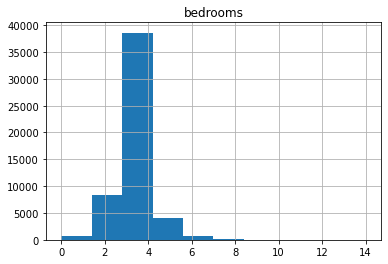

bathrooms


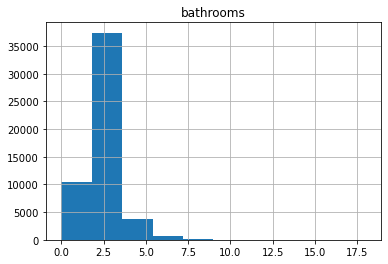

indoor_sqft


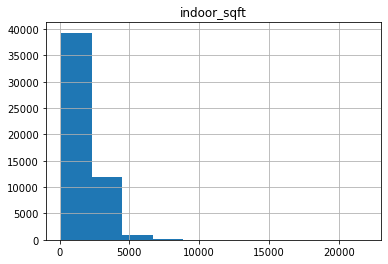

tax_value


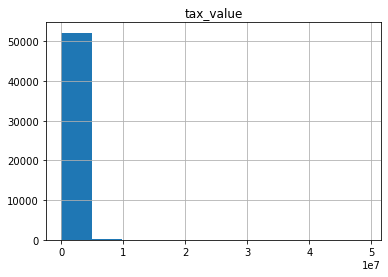

In [18]:
# Using a for loop to plot columns to observe outliers

for column in houses.columns:
    print(column)
    plt.title(column)
    houses[column].hist()
    plt.grid(True)
    plt.show()

### Takeaways

**A first look shows me that there may be a lot of outliers because of the length of the x axis**

**The value still seem to be connected becase of the shape of the bars except for tax_value where it is not obvious**

<font color = 'brown'>**An observation with boxplots and countplots will give me a better view of the data**</font>

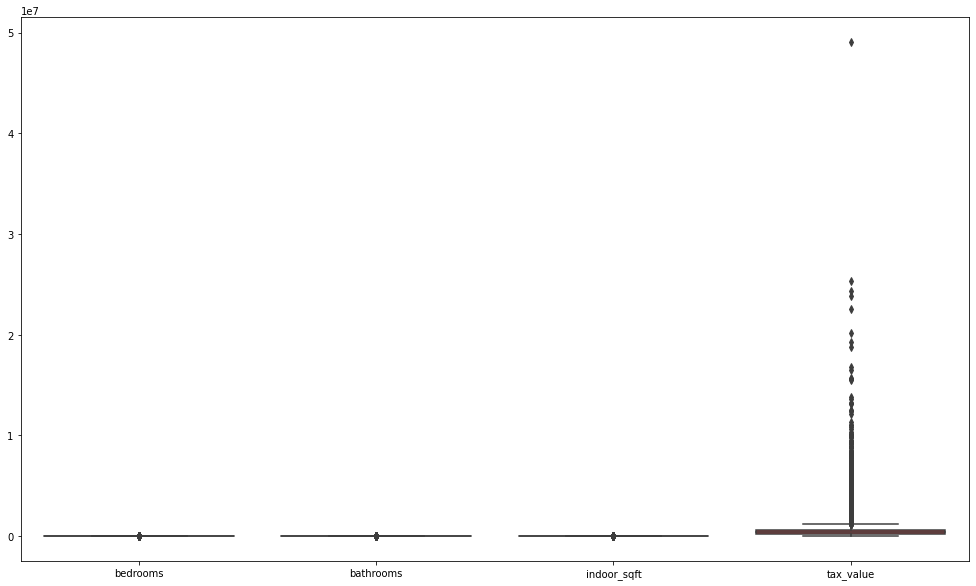

In [19]:
# Plotting a boxplot of all columns to have a better view

plt.figure(figsize=(17,10))
sns.boxplot(data=houses)
plt.show()

**Values are very different between tax_value and the others**


**I will plot them separately to havea better view**

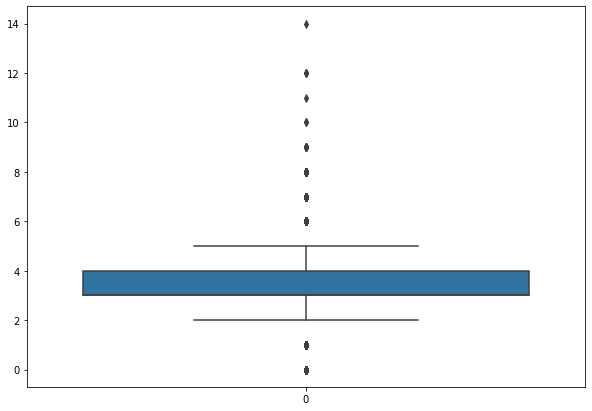

In [20]:
# Plotting data using a boxplot to understand distribution and see outliers

plt.figure(figsize=(10,7))
sns.boxplot(data=houses.bedrooms)
plt.show()

# There are lots of outliers

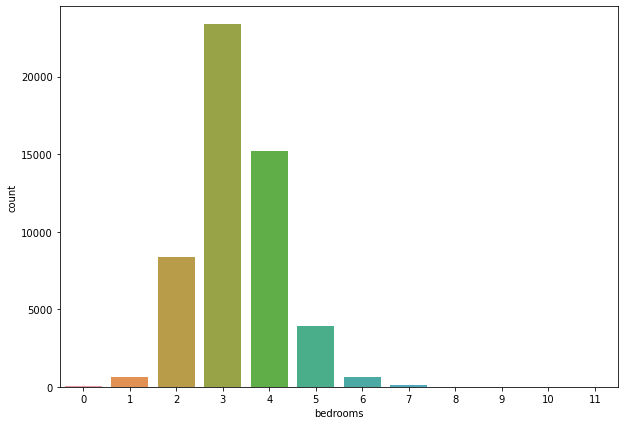

In [49]:
# Using a countplot to further investigate the distribution of the data

plt.figure(figsize=(10,7))
sns.countplot(x='bedrooms', data=houses)
plt.show()

**The bedrooms columns is surprisingly pretty normally distributed**

**It contains a great number of outliers**

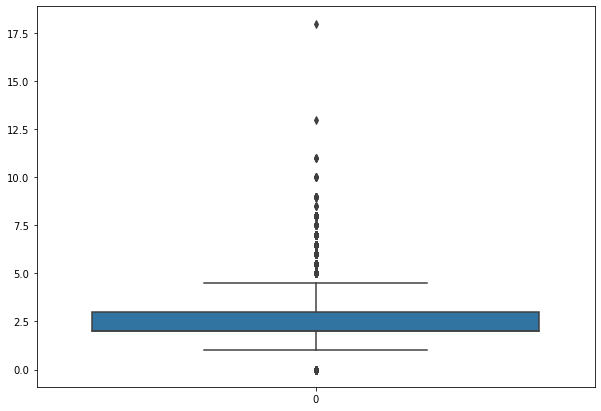

In [21]:
# Plotting data using a boxplot to understand distribution and see outliers

plt.figure(figsize=(10,7))
sns.boxplot(data=houses.bathrooms)
plt.show()

# There are lots of outliers

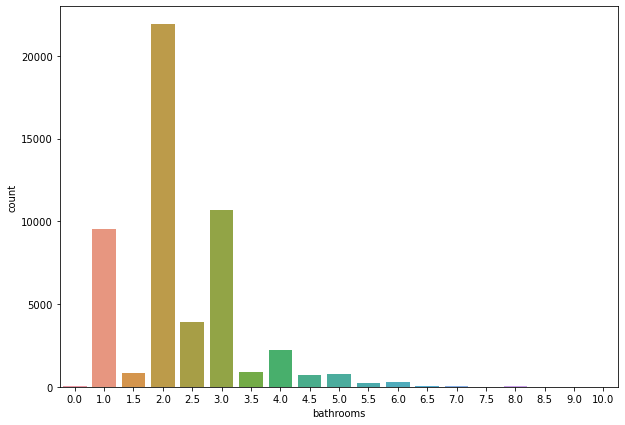

In [50]:
# Using a countplot to further investigate the distribution of the data

plt.figure(figsize=(10,7))
sns.countplot(x='bathrooms', data=houses)
plt.show()

**The bathrooms column is not really normally distributed**

**It contains a great number of outliers**

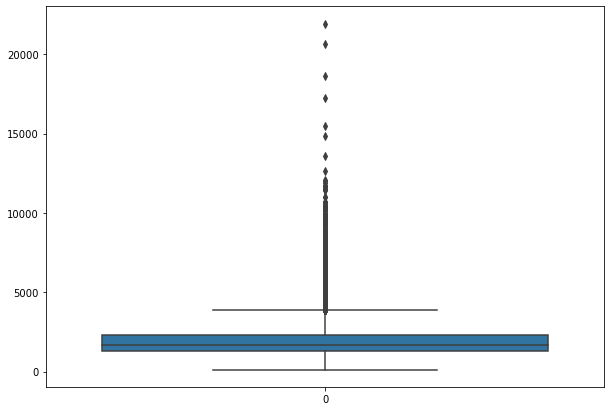

In [22]:
# Plotting data using a boxplot to understand distribution and see outliers

plt.figure(figsize=(10,7))
sns.boxplot(data=houses.indoor_sqft)
plt.show()

# There are lots of outliers in the indoor_sqft column

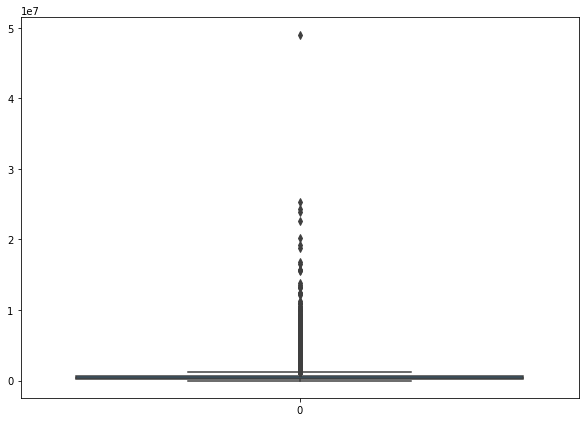

In [23]:
# Plotting data using a boxplot to understand distribution and see outliers

plt.figure(figsize=(10,7))
sns.boxplot(data=houses.tax_value)
plt.show()

# There are lots of outliers in the tax_value column but it is also the target variable so the current should be ok

## Takeaways

- All the columns have a lot of outliers
- They are mostly normally distributed which will help with the statistical analysis
- Since my goal is to predict the tax value of most houses, I will remove what does not constitute 'most houses in the US'
   * According to realtor.com, a mansion is in the real estate industry is a house that has 8,000 square feet and above.
   * I will cut off outliers that are 8,000 square feet and above.
- 0 bedroom and 0 bathroom do exist in the industry and it does not mean that the house does not have any or is not habitable
- .5, .25, .75 bathrooms exist as well and describe the existence of certain amenities in the bathroom like a tub or a sink...

In [24]:
# The proportion of houses that have 7_999 indoor_squarefeet and less

houses[houses.indoor_sqft <= 7_999].shape[0] / houses.shape[0]

0.99791821845337

In [25]:
# Mean of number of bedroooms of houses corresponding to less than 8_000 sqft

houses[houses.indoor_sqft <= 7_999].bedrooms.mean()

3.2996363636363637

In [26]:
# Mean of number of bathrooms of houses corresponding to less than 8_000 sqft

houses[houses.indoor_sqft <= 7_999].bathrooms.mean()

2.292124401913876

## Takeaways
- The proportion obtained are still significant and won't denature the data
- I will filter the data through the <= 7_999 square feet criterion

In [27]:
# Filtering the data through number of bedrooms

houses = houses[houses.indoor_sqft <= 7_999]
houses.head()

,bedrooms,bathrooms,indoor_sqft,tax_value
0,4,3.5,3100,1023282
1,2,1.0,1465,464000
2,3,2.0,1243,564778
3,4,3.0,2376,145143
4,4,3.0,2962,773303


In [28]:
# Verifying the state of the dataframe by checking number of null values,
# column and row numbers as well as data type

houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52250 entries, 0 to 52441
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     52250 non-null  int64  
 1   bathrooms    52250 non-null  float64
 2   indoor_sqft  52250 non-null  int64  
 3   tax_value    52250 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.0 MB


In [29]:
# Checking the precentage of null values in the dataframe

houses.isnull().mean()

bedrooms       0.0
bathrooms      0.0
indoor_sqft    0.0
tax_value      0.0
dtype: float64

## General Takeaways for univariate exploration
- The median of the indoor_sqft column is toward the bottom 50% of the data
- The median of bedrooms and bathrooms columns are not visible
- The .describe() function shows that the median in probably toward the bottom 25% of the data
- The data still contains a fair number of outliers. I think that an appropriate scaler (Robust or Quantile) can handle that
- It is probable that a type of Robust Scaler (Robust or Quantile) or a Standard scaler would work best

# III. Scaling and Exploration

**I will scale the data but assign the scaled data to a different variable tahn train and explore my train data with the train dataframe**

    - I will use a Min-Max, Standard, and Robust scalers
    - I will perform an exploration of the data to determine which columns are potential drivers of the tax value
    - For the exploration I will use appropriate charts and statistical tests to show that there is or there is not a correlation between the independent variables (bedrooms, bathrooms, and square footage) and the dependent one, tax value.

## A. Splitting and Scaling

**First I am going to split the data into train, validate, and test**

### 1. Splitting

### <font color = 'brown'>Train, Validate, and Test</font>

In [37]:
# Splits df into train_validate and test using train_test_split()
train_validate, test = train_test_split(houses, test_size=.2, random_state=175)

# splits train_validate into train and validate using train_test_split()
train, validate = train_test_split(train_validate, test_size=.3, random_state=175)

In [93]:
# Verifying the number of columns and rows in the split data (train, validate, and test)

train.shape

(29260, 4)

In [94]:
validate.shape

(12540, 4)

In [95]:
test.shape

(10450, 4)

In [96]:
train.columns.tolist()

['bedrooms', 'bathrooms', 'indoor_sqft', 'tax_value']

### <font color = 'brown'>The y_train, y_validate, and y_test</font>

In [122]:
y_train = train.tax_value
y_validate = validate.tax_value
y_test = test.tax_value

In [127]:
I will confirm that y_train is a series

y_train?
# y_train is indeed a series

### 2. Scaling

**Now I will create a dataframe that holds the features 'bedrooms', 'bathrooms', 'indoor_sqft' only**


In [100]:
# Creating a dataframe that holds the features 'bedrooms', 'bathrooms', 'indoor_sqft' only

for_scaling_train = train.drop(['tax_value'], axis=1)

for_scaling_train.head()

,bedrooms,bathrooms,indoor_sqft
47579,2,2.0,1313
48106,4,3.0,2629
31105,3,2.0,1648
12420,3,2.0,1580
16659,4,5.0,2547


In [101]:
# Creating a dataframe that holds the features 'bedrooms', 'bathrooms', 'indoor_sqft' only for the validate set

for_scaling_validate = validate.drop(['tax_value'], axis=1)

for_scaling_validate.head()

,bedrooms,bathrooms,indoor_sqft
21269,3,2.0,1321
14154,4,2.0,2299
12063,3,2.0,1550
22428,2,2.0,1296
13790,3,2.0,1848


In [102]:
# Creating a dataframe that holds the features 'bedrooms', 'bathrooms', 'indoor_sqft' only for the test set

for_scaling_test = test.drop(['tax_value'], axis=1)

for_scaling_test.head()

,bedrooms,bathrooms,indoor_sqft
26094,3,2.0,1425
43255,3,2.0,1342
8763,3,3.0,2994
39117,3,1.5,1150
48840,2,2.0,1411


**My next step is to create a Scaler Variable for each type of Scaler I am going to use (Standard, Robust, and Quantile)**

### <font color = 'brown'>Standard Scaler</font>

In [107]:
# Applying the standard scaler to the train data

standard_scaler1 = sklearn.preprocessing.StandardScaler()

standard_scaler1.fit(for_scaling_train)

StandardScaler()

In [108]:
# Applying the standard scaler to the validate data

standard_scaler2 = sklearn.preprocessing.StandardScaler()

standard_scaler2.fit(for_scaling_validate)

StandardScaler()

In [109]:
# Applying the standard scaler to the test data

standard_scaler3 = sklearn.preprocessing.StandardScaler()

standard_scaler3.fit(for_scaling_test)

StandardScaler()

**I will now scale the data with Standard Scaler**

In [110]:
X_train_standard = standard_scaler1.transform(for_scaling_train)
X_validate_standard = standard_scaler2.transform(for_scaling_validate)
X_test_standard = standard_scaler3.transform(for_scaling_test)

In [111]:
# Checking the shape and content of the X_train_standard to make sure it returns the expected array

X_train_standard

array([[-1.40188473, -0.29474639, -0.63235425],
       [ 0.75344444,  0.71329282,  0.76984155],
       [-0.32422014, -0.29474639, -0.27541231],
       ...,
       [-1.40188473, -0.29474639, -0.4064686 ],
       [ 0.75344444, -0.29474639, -0.58440683],
       [ 0.75344444,  0.71329282,  0.88384987]])

### <font color = 'brown'>**Robust Scaler**</font>

In [112]:
robust_scaler1 = sklearn.preprocessing.RobustScaler()

robust_scaler1.fit(for_scaling_train)

RobustScaler()

In [113]:
robust_scaler2 = sklearn.preprocessing.RobustScaler()

robust_scaler2.fit(for_scaling_validate)

RobustScaler()

In [114]:
robust_scaler3 = sklearn.preprocessing.RobustScaler()

robust_scaler3.fit(for_scaling_test)

RobustScaler()

In [115]:
# Applying the robust scaler to the train data

X_train_robust = standard_scaler1.transform(for_scaling_train)
X_validate_robust = standard_scaler2.transform(for_scaling_validate)
X_test_robust = standard_scaler3.transform(for_scaling_test)

In [116]:
# Checking the shape and content of the X_train_robust to make sure it returns the expected array

X_train_robust

array([[-1.40188473, -0.29474639, -0.63235425],
       [ 0.75344444,  0.71329282,  0.76984155],
       [-0.32422014, -0.29474639, -0.27541231],
       ...,
       [-1.40188473, -0.29474639, -0.4064686 ],
       [ 0.75344444, -0.29474639, -0.58440683],
       [ 0.75344444,  0.71329282,  0.88384987]])

### <font color = 'brown'>**Quantile Scaler**</font>

In [117]:
quantile_scaler1 = sklearn.preprocessing.QuantileTransformer()

quantile_scaler1.fit(for_scaling_train)

QuantileTransformer()

In [118]:
quantile_scaler2 = sklearn.preprocessing.QuantileTransformer()

quantile_scaler2.fit(for_scaling_validate)

QuantileTransformer()

In [119]:
quantile_scaler3 = sklearn.preprocessing.QuantileTransformer()

quantile_scaler3.fit(for_scaling_test)

QuantileTransformer()

In [120]:
# Applying the quantile scaker to the train data

X_train_quantile = quantile_scaler1.transform(for_scaling_train)
X_validate_quantile = quantile_scaler2.transform(for_scaling_validate)
X_test_quantile = quantile_scaler3.transform(for_scaling_test)

In [121]:
# Checking the shape and content of the train_scaled_standard to make sure it returns the expected array

X_train_quantile

array([[0.09159159, 0.40990991, 0.28228228],
       [0.76476476, 0.7957958 , 0.82802803],
       [0.3953954 , 0.40990991, 0.49572489],
       ...,
       [0.09159159, 0.40990991, 0.42192192],
       [0.76476476, 0.40990991, 0.31131131],
       [0.76476476, 0.7957958 , 0.84704008]])

**After finishing all these splits and scalers I realized that I don't need all of them for my MVP so I will choose just one for my MVP and come back to the others if I have enough time**

## B. Exploration on unscaled data

## Bedrooms column

**Hypothesis setting**
- Null hypothesis: $H_{0}$: there is no correlation between the number of bedrooms and the tax value of the properties


- Alternative hypothesis: $H_{A}$: there is a correlation between the number of bedrooms and the tax value of the properties.

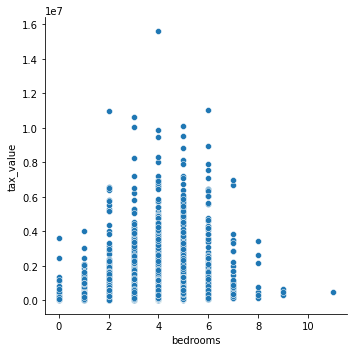

In [66]:
# Plotting a scatter plot to visualize the existence or not of a correlation before running a statistical test

sns.relplot(x='bedrooms', y='tax_value', data=train)
plt.show()

<AxesSubplot:xlabel='bedrooms', ylabel='tax_value'>

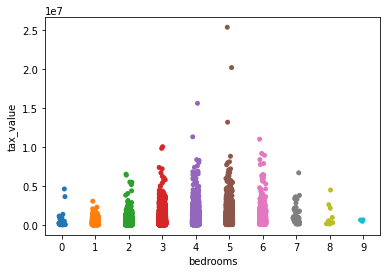

In [59]:
# Using a stripplot to further investigate the data

sns.stripplot(x='bedrooms', y='tax_value', data=train)

* Observations
    - The scatter plot and the strip plot display slightly different distribution of the data
        - 11 bedroom outlier missing in strip plot
        - outliers better represented
        - I would rather use the information from the scatter plot
    - As the number of bedrooms go from 0 to 7, I notice that there is an increase of the tax value af the properties
    - A great number of properties (with 0 to 11 bedrooms) have their prices conglomerated between the tax value of 0.0 and 0.6*10^7
    - The number of bedrooms is not always synonnymous of greater tax value
    - There is a 4 bedroom property that has a tax value far greater than all the other properties
    - Overall there doesn't seem to be a clear linear relationship between the two series
* Action

    - Perform statistical analyses to determine the correlation between the two variables (the shape of the chart and the nature of the data hints towards a spearman test su)

In [62]:
# I'll perform a Pearson test first to see the the level of correlation

bedrooms_pearsonr = stats.pearsonr(train.bedrooms, train.tax_value)
r, p = bedrooms_pearsonr

print(f'r is {r:.3f}')
print(f'p is {p:.10f}')

r is 0.262
p is 0.0000000000


<font color = 'brown'>**There is correlation because the p value is 0 up to 10 decimals and I can reject the null hypothesis. However, r is low = 0.26 meaning that 26% of the variation is explained by the relationship Bedrooms/Tax value. This does not surprise me because tax value goes up, then down, and remain the same in some case while bedrooms goes up**</font>

I will perform a spearman test to further investigate but the shape of the graph tells me <font color = 'brown'>**I may need a Hoeffding D test**</font> as well but I will leave it for later if I have time

In [63]:
# Performing a Spearman test to further investigate the correlation between bedrooms and tax value

bedrooms_spearmanr = stats.spearmanr(train.bedrooms, train.tax_value)
r, p = bedrooms_spearmanr

print(f'r is {r:.3f}')
print(f'p is {p:.10f}')

r is 0.296
p is 0.0000000000


<font color = 'brown'>**There is correlation because the p value is 0 up to 10 decimals and I can reject the null hypothesis. However, r is low = 0.29 meaning that 29% of the variation is explained by the relationship Bedrooms/Tax value. This does not surprise me because tax value goes up, then down, and remain the same in some case while bedrooms goes up**</font>

## Bathrooms column

**Hypothesis setting**
- Null hypothesis: $H_{0}$: there is no correlation between the number of bathrooms and the tax value of the properties


- Alternative hypothesis: $H_{A}$: there is a correlation between the number of bathrooms and the tax value of the properties.

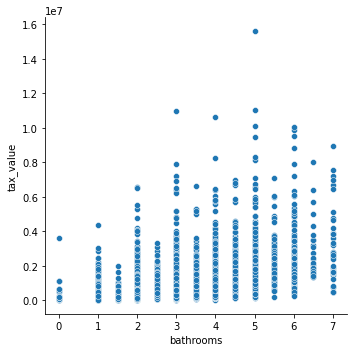

In [83]:
# Plotting a scatter plot to visualize the existence or not of a correlation before running a statistical test

sns.relplot(x='bathrooms', y='tax_value', data=train)
plt.show()

<AxesSubplot:xlabel='bathrooms', ylabel='tax_value'>

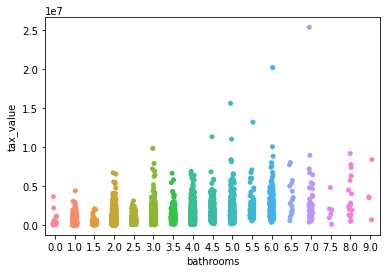

In [60]:
# Using a stripplot to further investigate the data

sns.stripplot(x='bathrooms', y='tax_value', data=train)

* Observations
    - Here too the scatter plot performs better. I will use it instead
    - The correlation seems stronger here because it mostly goes up except for a few outliers
    - One constant is that up to a certain tax value, about 0.3, there are houses with 0 to 7 bathrooms except for 6.5 bathrooms
    - There are no houses with 0.5 bathrooms
* Action
    - Perform a Pearson then if necessary a Spearman analysis to test for correlation

In [64]:
# I'll perform a Pearson test first to see the level of correlation

bathrooms_pearsonr = stats.pearsonr(train.bathrooms, train.tax_value)
r, p = bathrooms_pearsonr

print(f'r is {r:.3f}')
print(f'p is {p:.10f}')

r is 0.513
p is 0.0000000000


<font color = 'brown'>**There is correlation and I can reject the null hypothesis because the p value is 0 up to 10 decimals. The r value is twice as high here = 0.5**</font>

I will perform a spearman test to further investigate it

In [85]:
# Performing a Spearman test to see what insight it can provide

bathrooms_spearmanr = stats.spearmanr(train.bathrooms, train.tax_value)
r, p = bathrooms_spearmanr

print(f'r is {r:.3f}')
print(f'p is {p:.10f}')

r is 0.486
p is 0.0000000000


<font color = 'brown'>**There is correlation and I can reject the null hypothesis because the p value is 0 up to 10 decimals. The r value is lower than that of the Pearson one**</font>

I will consider the Pearson test result

## Indoor square footage column

**Hypothesis setting**
- Null hypothesis: $H_{0}$: there is no correlation between the indoor square footage and the tax value of the properties


- Alternative hypothesis: $H_{A}$: there is a correlation between the indoor square footage and the tax value of the properties.

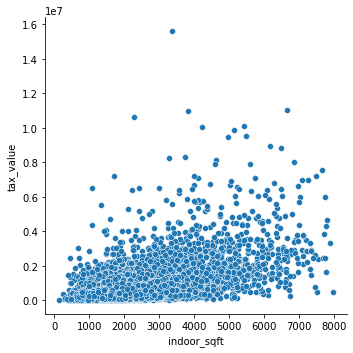

In [88]:
# Plotting a scatter plot to visualize the existence or not of a correlation before running a statistical test

sns.relplot(x='indoor_sqft', y='tax_value', data=train)
plt.show()

* Observations
    - There is a general upward tendency of the data with the with outliers here as well
    - The clustering of the data at the bottom of the graph (around y=tax_value= ~0.3) is still present
* Actions
    - Perform a Pearson then if necessary a Spearman analysis to test for correlation

In [65]:
# I'll perform a Pearson test first to see the level of correlation

indoor_sqft_pearsonr = stats.pearsonr(train.indoor_sqft, train.tax_value)
r, p = indoor_sqft_pearsonr

print(f'r is {r:.3f}')
print(f'p is {p:.10f}')

r is 0.582
p is 0.0000000000


<font color = 'brown'>**There is correlation and I can reject the null hypothesis because the p value is 0 up to 10 decimals. The r value is higher here = 0.6**</font>

I will perform a spearman test to further investigate it

In [66]:
# Performing a Spearman test to see what insight it can provide
# but from the shape of the data, I think it won't be more relevant

indoor_sqft_spearmanr = stats.spearmanr(train.indoor_sqft, train.tax_value)
r, p = indoor_sqft_spearmanr

print(f'r is {r:.3f}')
print(f'p is {p:.10f}')

r is 0.529
p is 0.0000000000


<font color = 'brown'>**There is correlation and I can reject the null hypothesis because the p value is 0 up to 10 decimals. The r value is lower than that of the Pearson one**</font>

I will consider the Pearson test result

In [67]:
houses.columns.tolist()

['bedrooms', 'bathrooms', 'indoor_sqft', 'tax_value']

## General Takeaways of Statistical Analysis
- There is a correlation between all the 3 columns bedrooms, bathrooms,  and indoor_sqft and tax_value
- indoor_sqft seems to have the strongest correlation
- I can move forward with

# IV. Modeling

## A. Data shape

**I will plot my data again to have a fresh view of it then I will choose the model(s) I think would best perform**

bedrooms


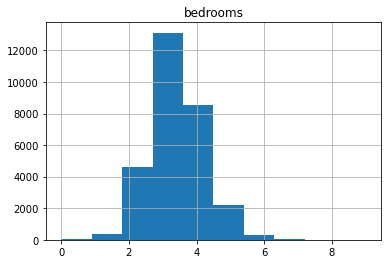

bathrooms


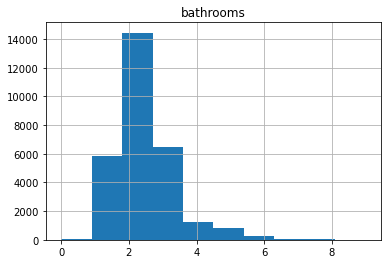

indoor_sqft


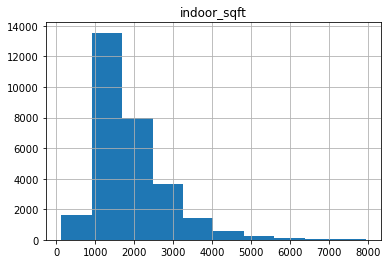

tax_value


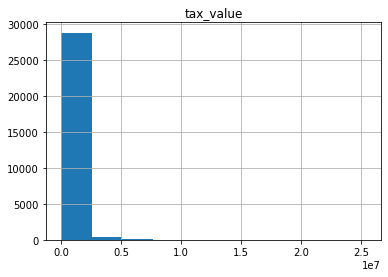

In [70]:
for column in train.columns:
    print(column)
    plt.title(column)
    train[column].hist()
    plt.grid(True)
    plt.show()

<AxesSubplot:xlabel='bedrooms', ylabel='count'>

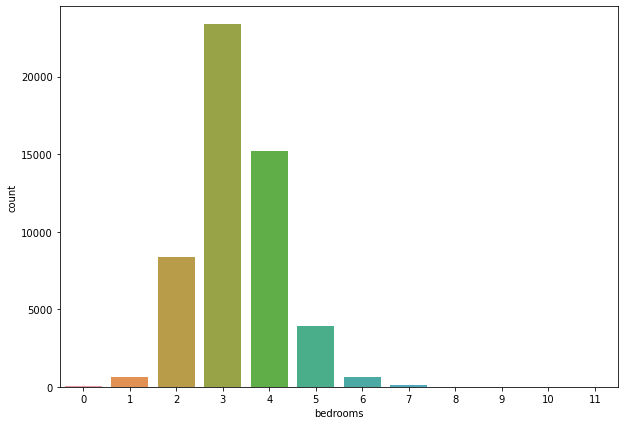

In [78]:
plt.figure(figsize=(10,7))
sns.countplot(x='bedrooms', data=houses)

<AxesSubplot:xlabel='bathrooms', ylabel='count'>

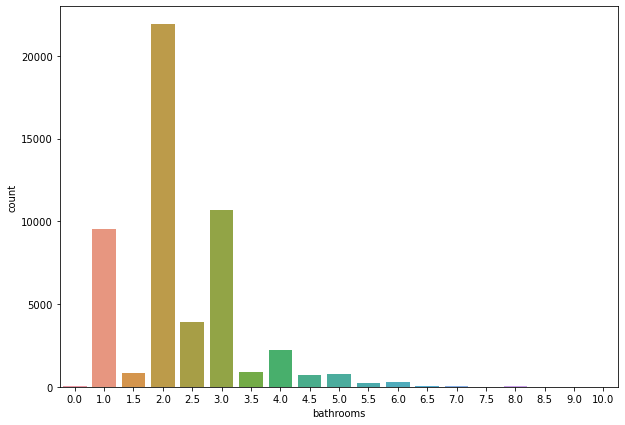

In [85]:
plt.figure(figsize=(10,7))
sns.countplot(x='bathrooms', data=houses)

* Observations
    - Tax_value does not really have a normal distribution and has a lot of outliers
    - bedrooms is the most normal looking distribution followed by indoor_sqft
    - bathroom is somewhat normally distributed
    - It seems like the best scaling tool would be Robust Scaler because 
    - It seems like the best modeling tool would be because 
* Actions
    - R 

## B. Modeling

### 1. Baseline

**I will establish the baseline through the mean and the median and compare.

**My hypothesis is that median would work best because there is a lot of outliers in y_train**

In [128]:
# I will set y_train and y_validate as dataframe first

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [129]:
# I will confirm that y_train has become a dataframe

y_train?
# y_train has become a dataframe

In [130]:
# I will confirm that y_validate has become a dataframe

y_validate?
# y_validate has become a dataframe

In [133]:
# Computing tax_value median

tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

In [135]:
# Computing tax_value mean

tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

In [137]:
# Displaying my median and mean

y_train.head()

,tax_value,tax_value_pred_median,tax_value_pred_mean
47579,629682,370998.0,514797.1811
48106,183245,370998.0,514797.1811
31105,564365,370998.0,514797.1811
12420,105997,370998.0,514797.1811
16659,854982,370998.0,514797.1811


**Time to evaluate the baseline**

In [146]:
# Calculating RMSE for median

rmse_train_median = math.sqrt(mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median))
rmse_validate_median = math.sqrt(mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median))

print('RMSE using the median\nTrain: ', rmse_train_median, '\nValidate: ', rmse_validate_median)

RMSE using the median
Train:  654028.5169540899 
Validate:  619700.2305704806


In [147]:
# Calculating RMSE for median

rmse_train_mean = math.sqrt(mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean))
rmse_validate_mean = math.sqrt(mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean))

print('RMSE using the mean\nTrain: ', rmse_train_mean, '\nValidate: ', rmse_validate_mean)

RMSE using the mean
Train:  638024.3698355088 
Validate:  602948.5814780932
